In [887]:
import sys
sys.path.append('svf')
from svf import svf

from echolab2.instruments import EK80
from echolab2.plotting.matplotlib import echogram

from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import numpy as np

alt_viridis = plt.cm.get_cmap('viridis', 256)
alt_viridis.set_under(color='white')
alt_viridis.set_bad(color='k')


In [888]:
# Here are some files to test with
file_dir = 'D:/FMCW/svf/data/fish/'
#file_dir = 'E:/BB/202207_EBS/EK80/*20220625*T11*'
#file_dir = 'E:/BB/202207_EBS/EK80/'
raw_files = sorted(glob(file_dir+'*.raw'))

In [889]:
raw_files

['D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T111653.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T111701.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T112414.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T113132.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T113857.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T114616.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T115336.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T120059.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T120829.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T121546.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T122250.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T122953.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T123656.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T124406.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T125108.raw',
 'D:/FMCW/svf/data/fish\\DY2207_EK80-D20220706-T125810.raw',
 'D:/FMCW/svf/data/fish\

In [890]:
# First step is to read in the raw files. These are big so it takes a bit
ek80 = EK80.EK80() # initiate the EK80 class in pyecholab
ek80.read_raw(raw_files[1]) # read in all the raw files in that directory or a subset

In [891]:
# The channel ids are also the dictionary keys for the data object
pulse = 0
data = ek80.get_channel_data()[ek80.channel_ids[pulse]][0]
cal = data.get_calibration()

# If you pull in separate gains...
# This is my personal version for pulling in the gains
#import gains
#gain = gains.gains()
#cal.gain = np.array([svf.pMean(gain.getGains(38,pulse)[1])]*data.n_pings)
#cal.sa_correction = np.array([0]*data.n_pings)

Text(0, 0.5, 'Range (m)')

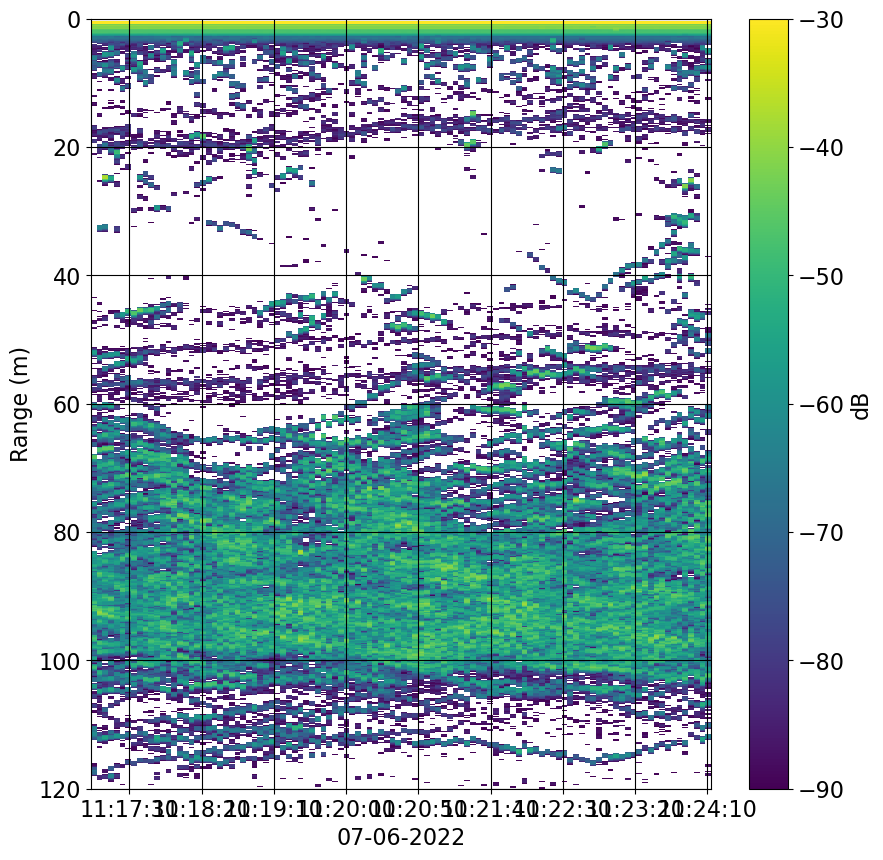

In [892]:
# Just to get an idea of what we're looking at
plt.rcParams['font.size'] = 12

# Get the sv data
Sv = data.get_Sv(calibration=cal)

# Example plot up the echogram
plt.rcParams['font.size'] = 16
fig_1 = plt.figure(figsize=(10,10))
eg = echogram.Echogram(fig_1, Sv,threshold=[-90,-30],cmap=alt_viridis)
eg.axes.set_ylim(0, 120)
eg.axes.invert_yaxis()
eg.add_colorbar(fig_1)
eg.axes.set_ylabel('Range (m)')
#eg.axes.set_xticks([Sv.ping_time[100],Sv.ping_time[-1]])

In [35]:
# This is how you integrate Sv(t)
from echolab2.processing import  line, grid,integration

interval_length =50 # set the length, this is in pings numbers but can be modified
layer_thickness = 5 # set the layer thickness, this is in meters but can be modified

# Initiate the grid and the integrator
g = grid.grid(interval_length=interval_length, interval_axis='ping_number',layer_axis='range',data=Sv, layer_thickness=layer_thickness)
i = integration.integrator(min_threshold_applied=False)

# Instead of reading in xyz files, I'm going to use manual lines for the exclude above and exclude below
exclude_above_line = line.line(ping_time=data.ping_time, data=5)
exclude_below_line = line.line(ping_time=data.ping_time, data=145)

# Integrate
i_2 = i.integrate(Sv,g,exclude_above_line=exclude_above_line,exclude_below_line=exclude_below_line)

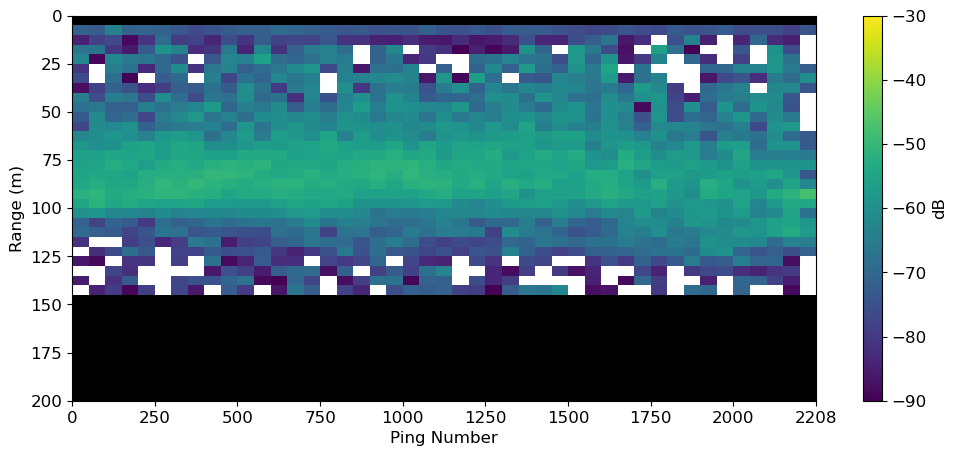

In [36]:
import numpy as np
fig_1 = plt.figure(figsize=(12, 5))
#fig_1 = plt.figure(figsize=(5, 12))
plt.pcolormesh(i_2.mean_Sv.T,vmin=-90,vmax=-30,cmap=alt_viridis)
plt.gca().set_xticks(np.arange(len(g.interval_edges))[::5]);
plt.gca().set_xticklabels([int(k) for k in g.interval_edges[::5]]);

plt.gca().set_yticks(np.arange(len(g.layer_edges))[::5]);
plt.gca().set_yticklabels([int(k) for k in g.layer_edges[::5]]);

plt.ylim(0,200/5)
plt.gca().invert_yaxis()

plt.xlabel('Ping Number')
plt.ylabel('Range (m)')
plt.colorbar(label='dB')

In [836]:
# And Here is how we get Svf. We use default step sizes for the Nfft and overlap
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
svf_results = svf.svf()
exclude_above = 5
exclude_below = 90

import time
start_time = time.time()
#svt_results_fm = svf.svt()

for freq in frequencies:
    inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None)
    #inputs.get_bottom_xyz() # Get the bottom line from the xyz files and add it to our inputs
    svf_results.calc_sample_Svf(inputs,exclude_above_line=exclude_above,exclude_below_line=exclude_below) 
    #svf_results.grid_Svf(inputs,interval_langth=25, layer_thickness=4)
    #svf_results.get_noise(inputs)
    #svf.write_grid_to_csv(svf_results,freq,output_dir="./svf/output/fish/") # If you want to write out the grid

    #svt_results_fm.grid_Svt(inputs, interval_length=50, layer_thickness=5,exclude_below_line='xyz', exclude_above_line=5,new_gain='G_fc_fm')
    print("--- %s seconds ---" % (time.time() - start_time))

--- 31.38265299797058 seconds ---
--- 78.41154837608337 seconds ---
--- 142.18856167793274 seconds ---
--- 262.6840431690216 seconds ---


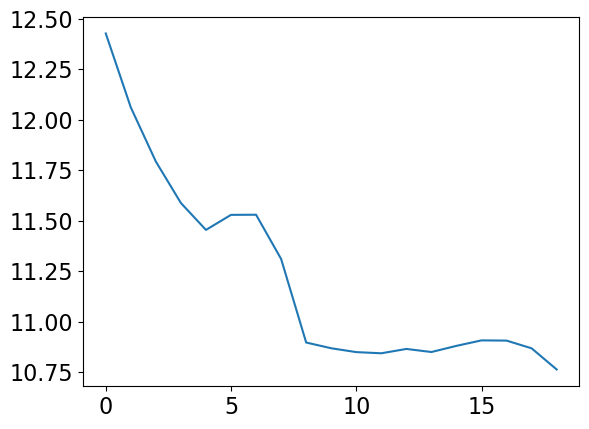

In [877]:
plt.plot(c2)

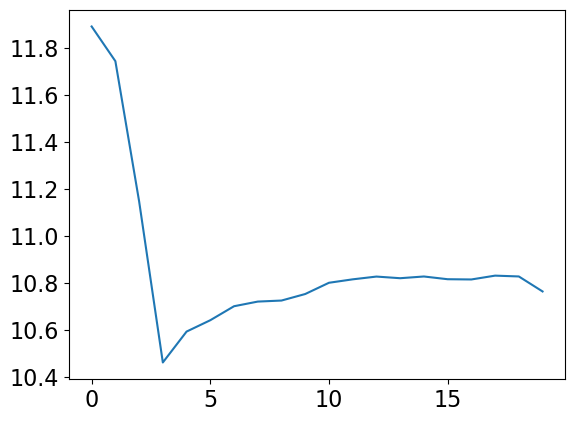

In [879]:
plt.plot(c2)

In [874]:
((f[-1]-f[0])*k)/2

47500.00000000002

Text(0.04, 0.5, 'Ping-to-ping variance relative to full bandwidth (dB)')

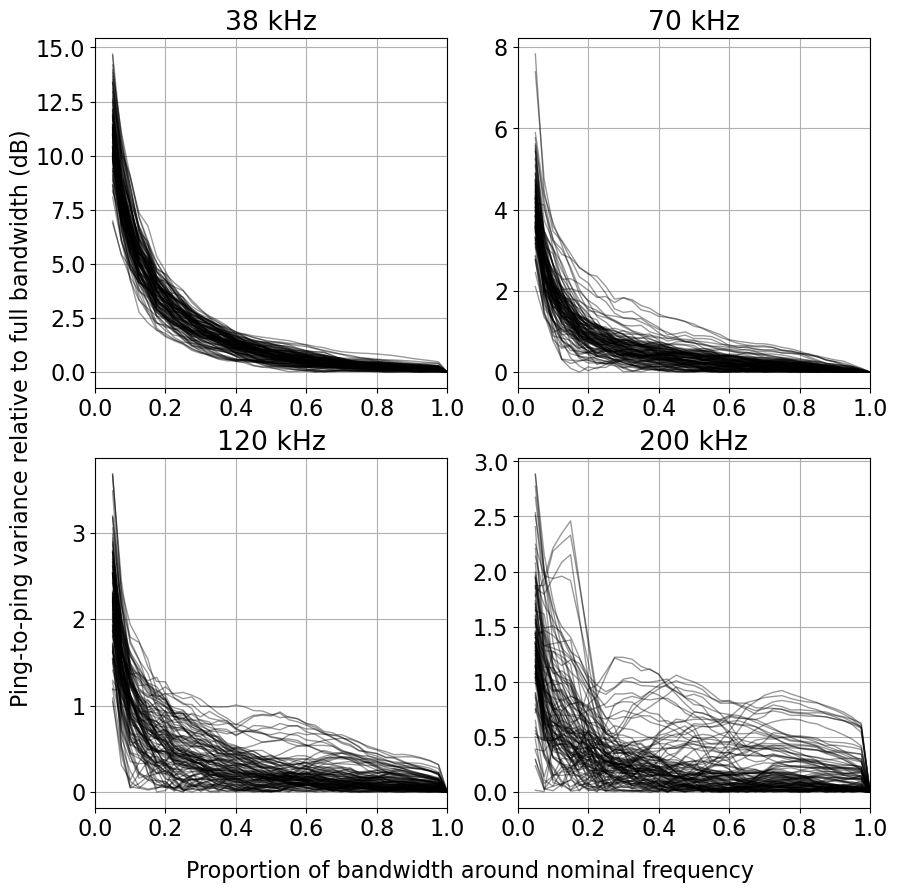

In [886]:
#ks = np.append(np.arange(500,95000,100),100000)
ks = np.append(np.arange(0.05,.976,.025),2)
sv = []
colors = {38000:'b',70000:'r',120000:'g',200000:'m'}
fc = {38000:39500,70000:70000,120000:125000,200000:212500}
ct = 1
fig = plt.figure(figsize=(10,10),dpi=100)
plt.rcParams['font.size'] = 16
for freq in [38000,70000,120000,200000]:
    plt.subplot(2,2,ct)
    f = svf_results.frequency[freq]
    for sample in np.where((svf_results.svf_range >5)&(svf_results.svf_range <60))[0]:#np.arange(0,340,10):
        b = []
        for ping in range(300,420):#range(len(svf_results.Sv_sample[freq])):
            a = []
            for k in ks:
                a.append(svf.pMean(svf_results.Sv_sample[freq][ping][sample][np.abs(f-freq)<((f[-1]-f[0])*k)/2]))
            sv.append(svf.pMean(svf_results.Sv_sample[freq][ping][sample]))
            b.append(a)
        c = []
        for ii in range(len(b[0])):
            c.append(stat.variance([j[ii] for j in b]))
            c2 = np.array(c)
        #plt.plot(np.append(ks[:-1],ks[:-1][-1]+1000),c2-c2[-1],'k',alpha=0.7,color=colors[freq],linewidth=1)
        plt.plot(np.append(ks[:-1],1),np.abs(c2-c2[-1]),'k',alpha=0.4,color='k',linewidth=1)
    plt.grid()
    plt.xlim(0,1)
    plt.title(str(int(freq/1000))+' kHz')
    ct+=1
    
    #inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None)
    #cwsv = inputs.data_cw.get_Sv()

    #for sample in np.where((cwsv.range >5)&(cwsv.range <50))[0]:
        #a = []
        #for ping in range(300,420):#range(len(cwsv.data))[:-200]:
            #a.append(cwsv.data[ping][sample])
        #plt.plot(1,stat.variance(a),'o',color=colors[freq],label=str(freq/1000)+' kHz')

#plt.ylabel('Ping-to-ping variance relative to full bandwidth (dB)')
#plt.xlabel('Proportion of bandwidth (Hz) around center frequency')

fig.text(0.5, 0.04, 'Proportion of bandwidth around nominal frequency', ha='center')
fig.text(0.04, 0.5, 'Ping-to-ping variance relative to full bandwidth (dB)', va='center', rotation='vertical')

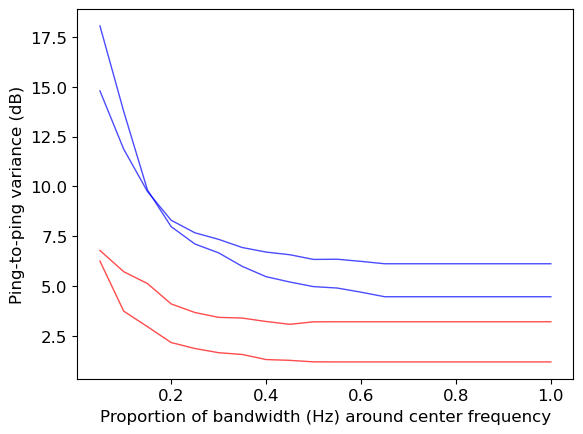

In [371]:
#ks = np.append(np.arange(500,5001,100),20000)
ks = np.arange(.05,1.01,.05)
sv = []
colors = {38000:'b',70000:'r'}
for freq in [38000,70000]:
    f = svf_results.frequency[freq]
    for sample in np.where((svf_results.svf_range >150)&(svf_results.svf_range <151))[0]:#np.arange(0,340,10):
        b = []
        for ping in range(100):
            a = []
            for k in ks:
                a.append(svf.pMean(svf_results.Sv_sample[freq][ping][sample][np.abs(f-freq)<(f[-1]-f[0])*k]))
            sv.append(svf.pMean(svf_results.Sv_sample[freq][ping][sample]))
            b.append(a)
        c = []
        for k in range(len(b[0])):
            c.append(stat.variance([j[k] for j in b]))
            c2 = np.array(c)
        #plt.plot(np.append(ks[:-1],ks[:-1][-1]+1000),c2-c2[-1],'k',alpha=0.7,color=colors[freq],linewidth=1)
        plt.plot(ks,c2,'k',alpha=0.7,color=colors[freq],linewidth=1)
    plt.grid()
    plt.ylabel('Ping-to-ping variance (dB)')
    plt.xlabel('Proportion of bandwidth (Hz) around center frequency')

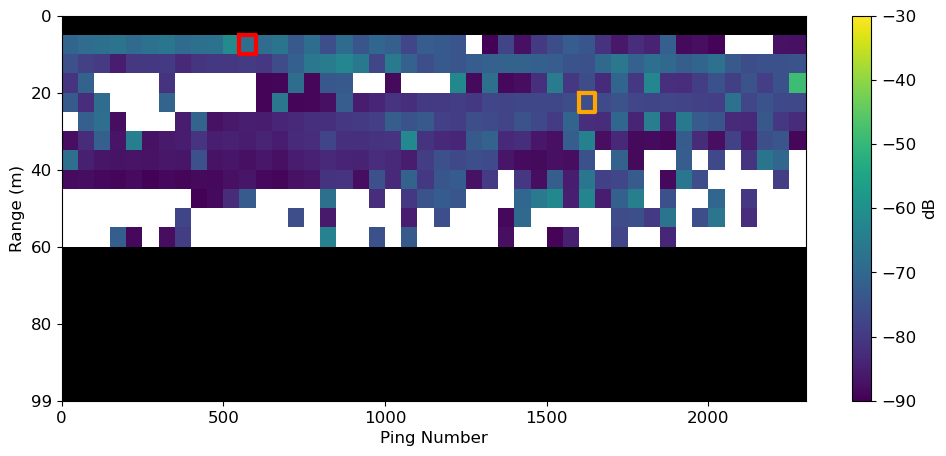

In [367]:
import numpy as np

colors=iter(["r", "orange", "purple"])

interval =[11,32] # These are 0-indexed
layer  = [1,4] # These are 0-indexed

fig_1 = plt.figure(figsize=(12, 5))
plt.pcolormesh(svf.pMean(svf_results.Sv_grid[38000],axis=2).T,vmin=-90,vmax=-30,cmap=alt_viridis)
plt.gca().set_xticks(np.arange(len(svf_results.g.interval_edges))[::10]);
plt.gca().set_xticklabels([int(k) for k in svf_results.g.interval_edges[::10]]);

plt.gca().set_yticks(np.arange(len(svf_results.g.layer_edges))[::4]);
plt.gca().set_yticklabels([int(k) for k in svf_results.g.layer_edges[::4]]);

plt.ylim(0,100/5)
plt.gca().invert_yaxis()

plt.xlabel('Ping Number')
plt.ylabel('Range (m)')
plt.colorbar(label='dB')


for interval_iter,layer_iter in zip(interval,layer):
    p = plt.plot([interval_iter,interval_iter+1,interval_iter+1,interval_iter,interval_iter],
             [layer_iter,layer_iter, layer_iter+1, layer_iter+1,layer_iter],linewidth=3,color= next(colors))

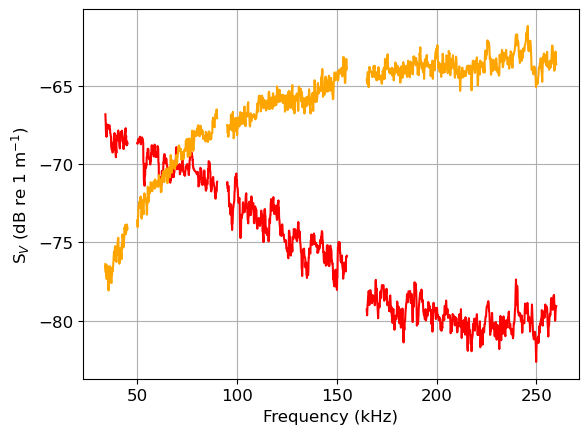

In [368]:
colors=iter(["r", "orange", "purple"])
for interval_iter,layer_iter,c in zip(interval,layer,box_colors):
    c=next(colors)
    for freq in frequencies:
        plt.plot(svf_results.frequency[freq]/1000, svf_results.Sv_grid[freq][interval_iter][layer_iter],color=c)
        #plt.plot(svf_results.frequency[freq]/1000, svf_results.Sv_noise_layer[freq][layer_iter],linestyle=':',color=c,alpha=0.5)
plt.xlabel('Frequency (kHz)')  
plt.ylabel('S$_{V}$ (dB re 1 m$^{-1}$)') 
plt.grid()

In [794]:
# Here are some files to test with
#file_dir = 'D:/FMCW/svf/data/fish/'
file_dir = 'E:/BB/202207_EBS/EK80/*20220611*T08*'
#file_dir = 'E:/BB/202207_EBS/EK80/'
raw_files = sorted(glob(file_dir+'*.raw'))
# First step is to read in the raw files. These are big so it takes a bit
ek80 = EK80.EK80() # initiate the EK80 class in pyecholab
ek80.read_raw(raw_files) # read in all the raw files in that directory or a subset

In [796]:
inputsdd

In [798]:
# And Here is how we get Svf. We use default step sizes for the Nfft and overlap
frequencies = [38000,70000,120000,200000] # set the frequencies to read in
svf_results = svf.svf()
freq = 38000
inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None)
Sv_sample_noise, frequency, svf_range = svf.calc_sample_Svf(inputs,ping_start=0,ping_end=50)

In [800]:
svf_range

array([  1.50528002,   1.97568002,   2.44608003, ..., 997.34209183,
       997.81249183, 998.28289184])

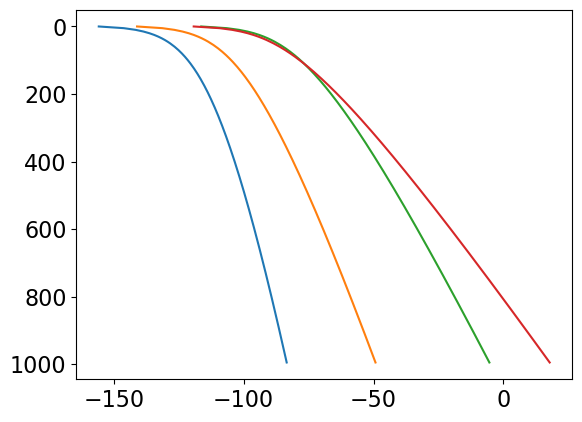

In [832]:
# And Here is how we get Svf. We use default step sizes for the Nfft and overlap
frequencies = [38000,70000,120000,200000] # set the frequencies to read in

for freq in frequencies:
    inputs = svf.inputs(ek80,freq,add_cw=True,frequency_resolution=None)
    Sv_sample_noise, frequency, svf_range = svf.calc_sample_Svf(inputs,ping_start=0,ping_end=50)

    hold_layer_noise = []
    for iter_layer in np.arange(0,np.max(svf_range), 5):
        layer_i = np.where([(svf_range>=iter_layer)&(svf_range<iter_layer+5)])[1]
        cur_cell_full = Sv_sample_noise[:,layer_i[0]:layer_i[-1]+1]
        hold_layer_noise.append(svf.pMean(svf.pMean(cur_cell_full,axis=1),axis=0)\
                                - (20*np.log10(iter_layer+2.5)) \
                                - (2*inputs.alpha_m*(iter_layer+2.5)))
    Sv_noise = np.nanmin(hold_layer_noise,axis=0)

    Sv_noise_bylayer = []
    for iter_layer in np.arange(0,np.max(svf_range), 5):
        Sv_noise_bylayer.append(Sv_noise+(20*np.log10((iter_layer+2.5)))\
            +(2*np.unique(inputs.alpha_m)*(iter_layer+2.5)))
        
    plt.plot([svf.pMean(Sv_noise_bylayer[k][np.where(np.abs(frequency-freq)<500)]) for k in range(len(Sv_noise_bylayer))],np.arange(0,np.max(svf_range), 5))
plt.gca().invert_yaxis()

In [833]:
files = sorted(glob(dataDir+'*.raw'))
    goodFiles, noBot = [],[]
    for file in files:
        if glob(dataDir+os.path.basename(file)[:-4]+'-ES38*-1.xyz'):
            goodFiles.append(file)
        else:
            noBot.append(file) # Files without xyz are passive so we'll make a separate list

NameError: name 'passive_lookup' is not defined